# <i class="fas fa-star"></i>&hairsp;Tutorial 04: Spatial Intersection Between Trees

This notebook demonstrates how to determine the spatial intersection and union between two neuronal arbors.
To demonstrate versatility, the bulk of computations are performed using established Python libraries: PySNT is simply used to obtain reconstructions, and its built-in converters convert them to point clouds of node coordinates and NetworkX graphs that are consumed by trimesh and numpy.

```{hint}
By the end of this notebook, you will be able to:
- Download morphologies from NeuronMorpho.org
- Use PySNT to convert SWC data into a NetworkX graph
- Compute spatial intersection and union of point clouds using trimesh
- Perform basic graph analysis
- Compute similarity indices for overlapping arbors

**Estimated Time**: 30-40 minutes
```

```{note}
Make sure to read these resources before running this notebook:
- [Install](../install.md) - Installation instructions
- [Quickstart](../quickstart.md) - Get started quickly
- [Overview](../overview.md) - Tour of pysnt's architecture
```

**Extra Requirements:**
- [trimesh](https://trimsh.org/)
  ```bash
  mamba activate pysnt
  mamba install trimesh
  ```
- [Blender](https://www.blender.org/) installation (used by trimesh for boolean operations). It is automatically detected when installed at default locations:
  - `C:\Program Files\Blender Foundation\Blender` (Windows)
  - `/Applications/` (macOS)
  - `/usr/bin/blender` or similar (linux) (use `which blender` to find out the full path to your Blender executable)


```{warning}
This notebook will only run if the Blender executable is available.
```

## Introduction

In this tutorial we will quantify the spatial overlap between the axonal and dendritic arbor of two of the most fascinating cells in the neocortex: Martinotti and Chandelier cells. We will compute their spatial overlap using two approaches: convex hull volumes, and cable length.

After we compute the convex hulls for two arbors, we can determine their spatial intersection and union, and quantify their similarity using the Jaccard coefficient.
The intersection volume represents the spatial overlap between the convex hulls of two arbors, while the union encompasses their combined extent. The Jaccard similarity coefficient can be used to quantify how similar the overall spatial territories occupied by two arbors are, yielding values from 0 (no overlap) to 1 (identical territories). It is defined as:


$$J(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}$$

where *A* and *B* are the convex hulls of the two dendritic trees (though any comparable geometric measure could be used, such as voxel occupancy or cable length).

By applying this metric to convex hulls, we obtain a coarse but computationally efficient measure of spatial similarity that captures whether neurons occupy overlapping spatial fields.

In this tutorial, we explore this approach as an academic example of how pySNT can be integrated with other Python tools like [trimesh](https://trimsh.org/) and [Blender](https://www.blender.org/). In practice, this methodology can be useful for quickly identifying cells with overlapping dendritic fields, comparing territorial coverage across populations, or filtering large datasets to find neurons with similar spatial distributions before performing more detailed morphometric analyses.


## Checking Requirements

We'll start first by making sure all of the required dependencies have been installed:

In [1]:
# Check if trimesh is available
try:
    import trimesh
    from trimesh import PointCloud
    from trimesh.boolean import intersection, union
    print("Trimesh is available")
except ImportError:
    print("Trimesh is not available: Notebook will not run!")

# Check if Blender is available
has_blender = trimesh.interfaces.blender.exists
if has_blender:
    import trimesh.interfaces.blender as blender_interface
    blender_path = blender_interface._blender_executable
    print(f"Blender found at: {blender_path}")
else:
    print("Blender is not available: Notebook will not run!")

Trimesh is available
Blender found at: /Applications/Blender.app/Contents/MacOS/blender


## Setting up

Our analysis will require us to:

1. Download neuronal arbors from NeuroMorpho.org
2. Compute a convex hull from the point cloud of reconstructed arbors
3. Compute the spatial intersection/union of the point cloud
4. Display the data

We can assign these tasks to reusable functions:

1. `fetch_dendrite_and_axon()`: Downloads neurons ({class}`Tree <pysnt.Tree>`) from the NeuroMorpho.org database using {class}`NeuroMorphoLoader <pysnt.io.NeuroMorphoLoader>`
2. `get_node_coordinates()`: Converts Tree nodes into a numpy array of X,Y,Z coordinates to be used by trimesh
3. `get_intersection_and_union_hulls()`: Computes the spatial intersection and union between point clouds of node coordinates using trimesh and Blender
4. `display()`: Assembles a 3D scene for visualization using {class}`Viewer3D <pysnt.viewer.Viewer3D>`

**Detailed Guides:**
- {doc}`Tree </pysnt/tree_doc>`
- {doc}`NeuroMorphoLoader </pysnt/io/neuromorpholoader_doc>`
- {doc}`Viewer3D </pysnt/viewer/viewer3d_doc>`


In [2]:
def fetch_dendrite_and_axon(neuro_morpho_cell_id):
    """Returns the tuple of pysnt.Tree objects (dendrite, axon) of a cell from NeuroMorpho.org."""
    from pysnt.io import NeuroMorphoLoader
    loader = NeuroMorphoLoader()
    if not loader.isDatabaseAvailable():
        print("Error: Could not reach NeuroMorpho.org")
        return None
    tree = loader.getTree(neuro_morpho_cell_id)

    # In these reconstructions the dendritic arbor is rooted on a soma-tagged path,
    # so we need to include it in the dendrite subtree to obtain a valid structure.
    dendrite = tree.subTree('dendrite', 'soma')
    axon = tree.subTree('axon')
    return (dendrite, axon)


def get_node_coordinates(tree):
    """Return a 2D numpy array of node [x,y,z] coordinates for all nodes of the given pysnt.Tree."""
    import numpy as np

    # Get tree nodes as a list of pysnt.util.PointInImage objects
    points = tree.getNodes()
    
    # Get x,y,z coordinates from PointInImage objects
    points_iterator = points.iterator()
    points_list = []
    while points_iterator.hasNext():
        p = points_iterator.next()
        points_list.append([p.x, p.y, p.z])

    return np.asarray(points_list)


def get_intersection_and_union_hulls(trees):
    """Return a 2D numpy array of node [x,y,z] coordinates for all nodes of the given pysnt.Tree."""
    from trimesh import PointCloud
    from trimesh.boolean import intersection, union

    meshes = []
    for tree in trees:
    
        # Find the convex hull of the tracing with trimesh
        tree_points = get_node_coordinates(tree)
        tree_cloud = PointCloud(tree_points)
        tree_hull = tree_cloud.convex_hull
        meshes.append(tree_hull)
    
    # Get spatial intersection of both hulls as another convex hull
    intersection_hull = intersection(meshes, engine='blender')
    if len(intersection_hull.vertices) == 0:
        print("No spatial overlap found, exiting.")
        return
    
    # Compute the union hull of both hulls
    union_hull = union(meshes, engine='blender')
    
    return (intersection_hull, union_hull)


def display(trees, hulls):
    from pysnt.util import SNTPoint, SNTColor
    from pysnt.viewer import Viewer3D

    viewer = Viewer3D()
    viewer.setEnableDarkMode(False)

    # Assign a unique color to each tree, excluding dim hues
    tree_colors = SNTColor.getDistinctColors(len(trees), 'dim')
    for index, tree in enumerate(trees):
        tree.setColor(tree_colors[index])
    viewer.add(trees)

    # Render each hull mesh as a semi-transparent surface. In
    # Viewer3D, surface annotations are created from SNTPoints,
    # so we need to convert individual hull vertices
    hue_colors = SNTColor.getDistinctColors(len(hulls), 'dim')
    for index, hull in enumerate(hulls):
        verts_list = []
        for v in hull.vertices:
            verts_list.append(SNTPoint.of(v[0], v[1], v[2]))
        surface = viewer.annotateSurface(verts_list, "Hull {}".format(index))
        surface.setColor(hue_colors[index], 90) # transparency (%)
    
    return viewer

Now that core functions have been defined, we start—as always—by initializing pysnt. We'll also set the same generic options we have been using in these tutorials.

```{tip}
If your operating system supports it, consider enabling interactive mode when initializing SNT (`pysnt.initialize(mode='interactive')`) to display the 3D scene in a native window using `viewer.show()`. 

**Important:** On some systems, code execution will pause until the viewer window is closed. For non-blocking visualization during analysis, use the default `pysnt.display(viewer)` option instead. See [Quirks and Limitations](../limitations.md#interactive-viewers) for details.
```

In [15]:
import pysnt
pysnt.set_option('java.logging.level', 'Error') # Set logging level to 'Error' to reduce console output (see Overview for details)
pysnt.set_option('display.chart_format', 'svg') # SVG plots and histograms
pysnt.set_option('display.chart_dpi', 150) # Rendering resolution
pysnt.initialize()

Now that PySNT is initialized, we will define the two GABAergic cell types to be studied in this tutorial.

- **Chandelier cell**: Interneurons characterized by vertically oriented axonal "cartridges" that form synapses onto the axon initial segments of pyramidal neurons. Their arbors are relatively compact and column-like, typically extending across several cortical layers. Discovered in the 1970s, they were named by János Szentágothai due to the distinctive chandelier-like appearance of their axon terminals, which resemble candlesticks.

- **Martinotti cell**: Multipolar interneurons whose axons ascend to layer 1, where they form a horizontally spreading plexus that extends across multiple cortical columns, primarily contacting the apical dendritic tufts of pyramidal neurons. They were first described in the late 19th century by Carlo Martinotti, a student of Camillo Golgi.

Both cell types can be found by keyword search in NeuroMorpho.org. Note that publicly available reconstructions often have incompletely traced axonal arbors due to the technical difficulty of following fine, long-range axonal processes. Details about the chosen exemplars are available on their NeuroMorpho.org info pages: [Chandelier cell](https://neuromorpho.org/neuron_info.jsp?neuron_name=TT-01-08-14-1R) and [Martinotti cell](https://neuromorpho.org/neuron_info.jsp?neuron_name=FW20141007-1-1-Martinotti).

We can define a dictionary of lists to facilitate adding additional exemplars later:


In [4]:
cell_dict = {
    'Chandelier': [ 'TT-01-08-14-1R'], # 
    'Martinotti': [ 'FW20141007-1-1-Martinotti'] # 
}

For each cell, we now retrieve their axonal and dendritic arbors, extract their point clouds and compute the volumes associated with them:

FALLBACK (log once): Fallback to SW vertex for line stipple
FALLBACK (log once): Fallback to SW vertex processing, m_disable_code: 2000
FALLBACK (log once): Fallback to SW vertex processing in drawCore, m_disable_code: 2000


[SNTUtils] Retrieving org.scijava.Context...

[INFO] [SNT] 116 scijava services loaded
Chandelier, ID: TT-01-08-14-1R; Jaccard similarity: 0.024


Operating in headless mode - the original ImageJ will have limited functionality.


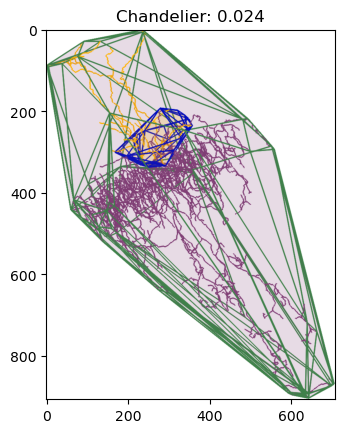

Martinotti, ID: FW20141007-1-1-Martinotti; Jaccard similarity: 0.144


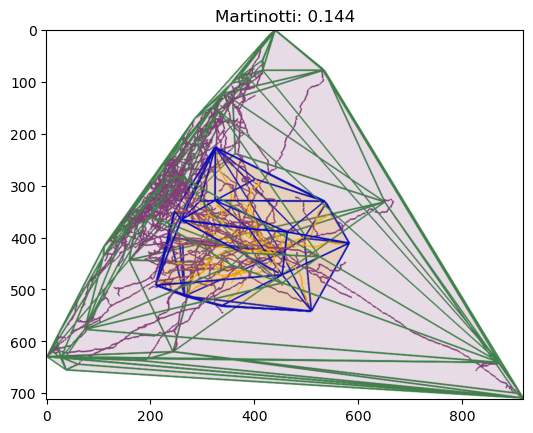

In [5]:
for cell_group, cell_ids in cell_dict.items():
    for id in cell_ids:

        # Retrieve dendritic and axonal arbors from NeuroMorpho.org
        dendrite, axon = fetch_dendrite_and_axon(id)

        # Retrieve convex hulls and their spatial intersection/union
        hulls = get_intersection_and_union_hulls([dendrite, axon])

        # Assemble a 3D scene with the original trees and their hulls
        viewer = display([dendrite, axon], hulls)

        # Compute Jaccard similarity index, and rename the viewer accordingly
        jaccard = (hulls[0].volume/hulls[1].volume)
        print("{}, ID: {}; Jaccard similarity: {:.3f}".format(cell_group, id, jaccard))
        title = "{}: {:.3f}".format(cell_group, jaccard)
        viewer.setTitle(title)

        # Display viewer in interactive mode if available
        if pysnt.get_mode() in ["gui", "interactive"]:
            viewer.show()
        else:
            pysnt.display(viewer, title=title)


## Graph Operations

Rather than using spatial intersection, we can also compute the total amount of cable length in the intersection volume. This is more conveniently achieved by treating reconstructions as [graph-theory Trees](https://en.wikipedia.org/wiki/Tree_(graph_theory)). 

In SNT, the underlying graph of a {class}`Tree <pysnt.Tree>` can be obtained using `getGraph()`:

In [6]:
dendrite_graph = dendrite.getGraph()
type(dendrite_graph)

<java class 'sc.fiji.snt.analysis.graph.DirectedWeightedGraph'>

### NetworkX Conversion

We could use the underlying {class}`DirectedWeightedGraph <pysnt.analysis.graph.DirectedWeightedGraph>` directly, but since we are focusing on leveraging native Python libraries in this tutorial, we'll convert it to a NetworkX graph. NetworkX is the _de facto_ Python standard for creating, manipulating, and analyzing the structure and dynamics of complex networks and graphs. As mentioned in previous tutorials, we use `pysnt.to_python()` for Java → Python conversions:

In [7]:
converted_object = pysnt.to_python(dendrite_graph)
print(type(converted_object))
for key, value in converted_object.items():
    print(" {}: {}".format(key, value))

<class 'dict'>
 type: <class 'networkx.classes.digraph.DiGraph'>
 data: DiGraph with 5955 nodes and 5954 edges
 metadata: {'source_type': 'SNTGraph', 'vertex_type': 'SWCPoint', 'edge_type': 'SWCWeightedEdge', 'vertex_count': 5955, 'edge_count': 5954, 'is_directed': True, 'layout': 'spring'}
 error: None


 `pysnt.to_python()` converts a Java SNT object into a Python counterpart. Invariably, the result is stored in a dictionary, with the following keys:
- `data`: The actual converted data (in our example, a NetworkX graph)
- `metadata`: Information about the original, converted object
- `error`: If conversion fails, information on the failure

To access converted data:

In [8]:
G = converted_object['data']
type(G)

networkx.classes.digraph.DiGraph

Converted objects can be displayed directly:

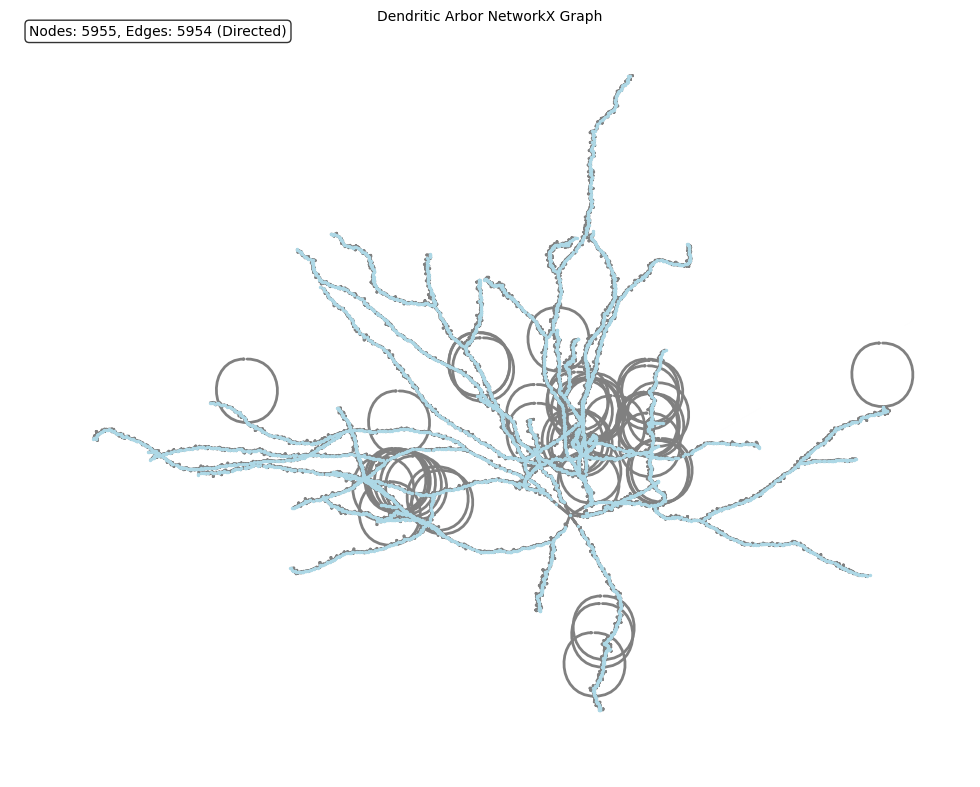

{'type': networkx.classes.digraph.DiGraph,
 'data': <networkx.classes.digraph.DiGraph at 0x31e856e40>,
 'metadata': {'source_type': 'SNTGraph',
  'vertex_type': 'SWCPoint',
  'edge_type': 'SWCWeightedEdge',
  'vertex_count': 5955,
  'edge_count': 5954,
  'is_directed': True,
  'layout': 'spring'},
 'error': None}

In [9]:
pysnt.display(converted_object, layout='spring', with_labels=False, arrows=True, node_size=2, arrowsize=1, title='Dendritic Arbor NetworkX Graph')

Operations with large graphs (thousands of vertices/edges) can be extremely slow. In these cases it is wiser to use a simplified graph, in which multiple edges are merged:

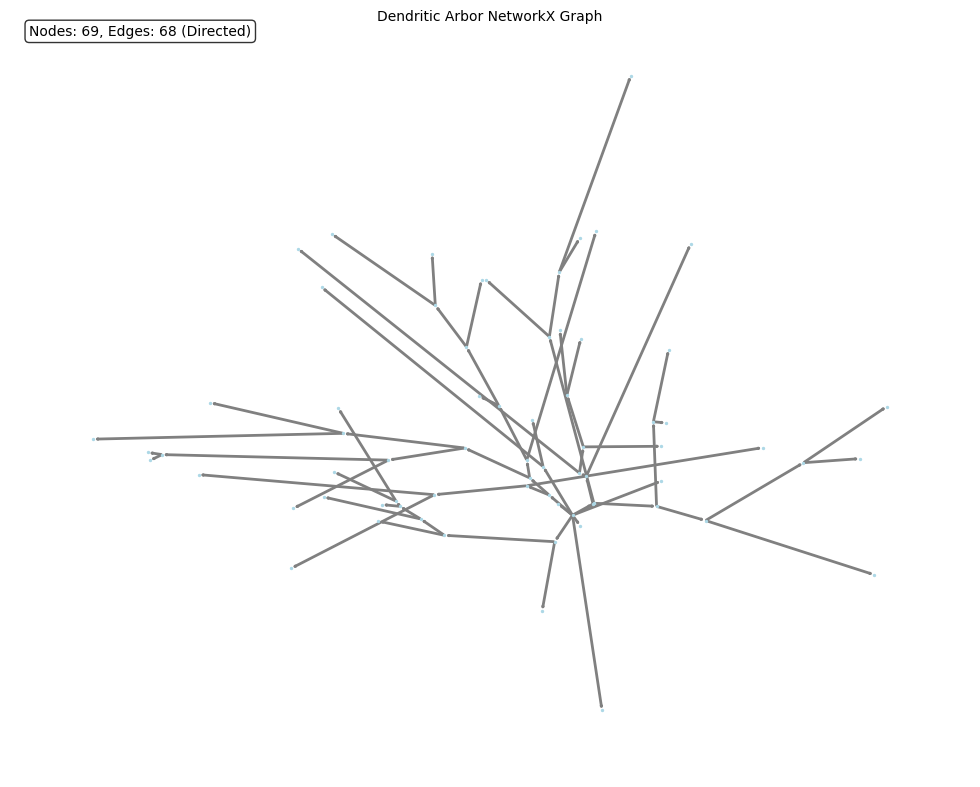

In [10]:
dendrite_graph = dendrite.getGraph(True) # simplified graph with merged edges
converted_object = pysnt.to_python(dendrite_graph)
G_simplified = converted_object['data']
pysnt.display(G_simplified, layout='spring', with_labels=False, arrows=True, node_size=2, arrowsize=1, title='Dendritic Arbor NetworkX Graph')

Which is much more manageable. Note that the simplification retains the original arbor size:

In [11]:
total_weight = G.size(weight="weight")
total_weight_simplified = G_simplified.size(weight="weight")

print("Original graph total weight (Cable length): {:.4f}µm".format(total_weight))
print("Simplified graph total weight (Cable length): {:.4f}µm".format(total_weight_simplified))  

Original graph total weight (Cable length): 4022.3932µm
Simplified graph total weight (Cable length): 4022.3932µm


### Computing Cable Lengths

For calculating the amount of linearized cable inside the intersection volume we need two functions: 1) A Tree → DiGraph converter; and 2) A function for summing the edge weights within a mesh:

In [12]:
def tree_to_networkx(tree):
    """Convert pySNT Tree to NetworkX graph."""
    snt_graph = tree.getGraph(True)  # pysnt.analysis.graph.DirectedWeightedGraph object
    result = pysnt.to_python(snt_graph)  # Returns SNTObject dict
    return result['data']  # Extract the NetworkX graph


def compute_cable_in_region_nx(G, region_mesh):
    """
    Compute total cable length in graph G within a mesh region.
    
    Parameters
    ----------
    G : networkx.DiGraph
        NetworkX graph converted from SNT Tree
    region_mesh : trimesh.Trimesh
        Trimesh convex hull
        
    Returns
    -------
    float
        Total cable length (in same units as graph coordinates) within the region
    """
    import numpy as np
    
    total_length = 0
    
    for u, v, data in G.edges(data=True):
        # Get node attributes
        u_attrs = G.nodes[u]
        v_attrs = G.nodes[v]
        
        # Extract 3D coordinates from node attributes
        p1 = np.array([u_attrs['x'], u_attrs['y'], u_attrs['z']])
        p2 = np.array([v_attrs['x'], v_attrs['y'], v_attrs['z']])
        
        # Get edge length (or compute if not available)
        if 'length' in data:
            segment_length = data['length']
        elif 'weight' in data:
            segment_length = data['weight']
        else:
            # Compute Euclidean distance
            segment_length = np.linalg.norm(p2 - p1)
        
        # Use sampling method for robustness
        n_samples = max(10, int(segment_length / 0.5))  # 0.5 µm resolution
        
        # Create sampled points along the edge
        # linspace creates points from p1 to p2
        t = np.linspace(0, 1, n_samples)[:, np.newaxis]  # Shape: (n_samples, 1)
        sampled_points = p1 + t * (p2 - p1)  # Shape: (n_samples, 3)
        
        # Check which points are contained in the mesh
        contained = region_mesh.contains(sampled_points)
        
        # Calculate fraction of edge inside the region
        fraction_inside = contained.sum() / n_samples
        
        # Add proportional length to total
        total_length += segment_length * fraction_inside
    
    return total_length


The only thing missing is to define a function to compute the Jaccard similarity index:

In [13]:
def compute_cable_jaccard_nx(graphs, intersection_region):
    """Compute Jaccard similarity based on cable length using NetworkX."""
    
    G_A = graphs[0]
    G_B = graphs[1]
    
    # Calculate cable lengths
    cable_A_intersection = compute_cable_in_region_nx(G_A, intersection_region)
    cable_B_intersection = compute_cable_in_region_nx(G_B, intersection_region)

    # The union length is the sum all edge weights
    cable_A_union = G_A.size(weight="weight")
    cable_B_union = G_B.size(weight="weight")

    # Jaccard coefficient
    total_intersection = cable_A_intersection + cable_B_intersection
    total_union = cable_A_union + cable_B_union
    jaccard_cable = total_intersection / total_union

    print("  Lengths in intersection volume: {:.3f}; {:.3f}".format(cable_A_intersection, cable_B_intersection))
    print("  Lengths in union volume: {:.3f}; {:.3f}".format(cable_A_union, cable_B_union))
    print("  Jaccard similarity (cable length): {:.3f}".format(jaccard_cable))

    return jaccard_cable

With the core functions defined, we can simply adjust the strategy used earlier:

Chandelier, Cell ID: TT-01-08-14-1R:
  Lengths in intersection volume: 541.599; 379.372
  Lengths in union volume: 1968.311; 17912.656
  Jaccard similarity (cable length): 0.046
  Lengths in intersection volume: 541.599; 379.372
  Lengths in union volume: 1968.311; 17912.656
  Jaccard similarity (cable length): 0.046


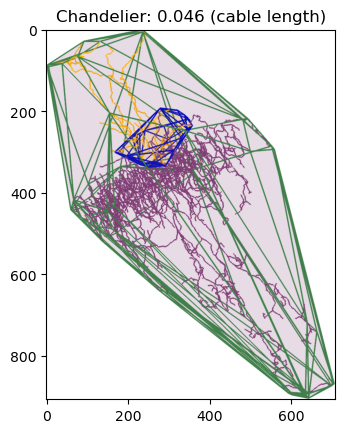

Martinotti, Cell ID: FW20141007-1-1-Martinotti:
  Lengths in intersection volume: 4015.368; 8230.445
  Lengths in union volume: 4022.393; 29700.639
  Jaccard similarity (cable length): 0.363
  Lengths in intersection volume: 4015.368; 8230.445
  Lengths in union volume: 4022.393; 29700.639
  Jaccard similarity (cable length): 0.363


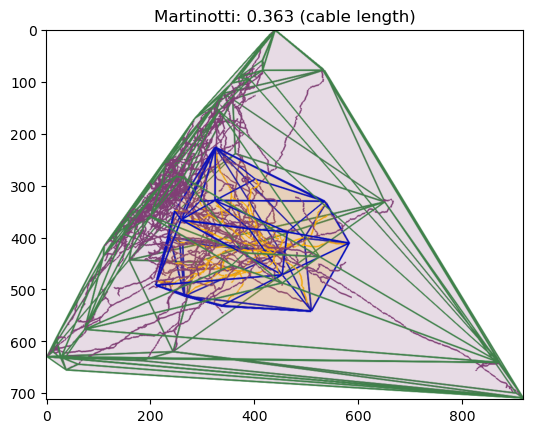

In [14]:
for cell_group, cell_ids in cell_dict.items():
    for id in cell_ids:
        print("{}, Cell ID: {}:".format(cell_group, id))
        dendrite, axon = fetch_dendrite_and_axon(id)
        dendrite_nx = tree_to_networkx(dendrite)
        axon_nx = tree_to_networkx(axon)
        hulls = get_intersection_and_union_hulls([dendrite, axon])
    
        jaccard_cable = compute_cable_jaccard_nx([dendrite_nx, axon_nx], hulls[0])
        title = "{}: {:.3f} (cable length)".format(cell_group, jaccard_cable)
        viewer = display([dendrite, axon], hulls)
        viewer.setTitle(title)

        # display viewer in interactive mode if available
        if pysnt.get_mode() in ["gui", "interactive"]:
            viewer.show()
        else:
            pysnt.display(viewer, title=title)

## Summary

In this tutorial, we performed specialized measurements on the spatial distribution of neuronal arbors. We intentionally restricted PySNT usage to I/O and visualization operations, delegating computational analysis to other Python libraries such as NetworkX and Trimesh.

## Follow-up Questions

1. What is the range of overlap between axons and dendrites across other Chandelier and Martinotti cells?
2. How do morphological differences between cell types (e.g., branching patterns, arbor density) contribute to overlap variability?
3. Axonal collaterals projecting to upper cortical layers likely account for the majority of processes in the intersection volume. How can this be tested? 

## Data Sources and References

Data in this notebook was obtained from [NeuroMorpho.Org](https://neuromorpho.org/) (RRID:SCR_002145) under a Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)):

- Tecuatl C, Ljungquist B, Ascoli GA (2024) Accelerating the continuous community sharing of digital neuromorphology data. FASEB Bioadv. 6(7):207-221. doi: [10.1096/fba.2024-00048](https://doi.org/10.1096/fba.2024-00048)

Chandelier cell(s) were downloaded from the Gonzalez-Burgos archive:

- Tikhonova TB, Miyamae T, Gulchina Y, Lewis DA, Gonzalez-Burgos G. Cell Type- and Layer-Specific Muscarinic Potentiation of Excitatory Synaptic Drive onto Parvalbumin Neurons in Mouse Prefrontal Cortex. eNeuro. 2018;5(5):ENEURO.0208-18.2018. Published 2018 Nov 15. [doi:10.1523/ENEURO.0208-18.2018](https://doi.org/10.1523/eneuro.0208-18.2018) [PMCID: PMC6354785](https://pmc.ncbi.nlm.nih.gov/articles/PMC6354785/)

Martinotti cell(s) were downloaded from the Staiger archive:

- Walker F, Möck M, Feyerabend M, et al. Parvalbumin- and vasoactive intestinal polypeptide-expressing neocortical interneurons impose differential inhibition on Martinotti cells. Nat Commun. 2016;7:13664. [doi:10.1038/ncomms13664](https://doi.org/10.1038/ncomms13664) [PMCID: PMC5141346](https://pmc.ncbi.nlm.nih.gov/articles/PMC5141346/)
